## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    val = sum(((1-2*int(b[k]))*(1-2*int(b[l])) for k,l in edges))
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

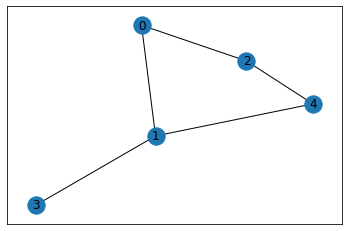

In [2]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [3]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 5.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblqr-1-0
  libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra libmagickwand-6.q16-6
  libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch inkscape libjxr-tools libwmf0.2-7-gtk
  poppler-uti

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()

    #in layer: use index instead of qbit instance
    for index_qbit in range(n_qubits):
      layer.apply(RX(theta), index_qbit)
    
    for k,l in edges:
      #(matrix use half angle)
      layer.apply(U_ZZ(2*beta), k, l)

    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu


def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    prog = Program()
    qubits = prog.qalloc(n_qubits)

    # TODO: implement initialization+parameterized circuit
    for q in qubits:
        # must iterate unlile qiskit
        prog.apply(H, q)

    for theta, beta in zip(parameters[::2], parameters[1::2]):
        prog.apply(
            one_qaoa_layer(n_qubits=n_qubits, edges=edges, theta=theta, beta=beta),
            qubits,
        )

    # END TODO
    circ = prog.to_circ()

    job = circ.to_job()
    qpu = get_default_qpu()

    result = qpu.submit(job)

    # BEGIN TODO
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        # sample.probability

        b = sample.state.bitstring
        p = sample.probability

        v = sum(((1 - 2 * int(b[k])) * (1 - 2 * int(b[l])) for k, l in edges))
        obs += v * p

    # END TODO
    return obs


In [7]:
import numpy as np
np.random.random(3)

array([0.39918484, 0.79448265, 0.51223719])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
On the cell below, we observe we need at least 8 layers to reach the optimal value

-0.9043604995027555 -1.4505048383265613 -1.7770927934321672 -2.4387478821105923 -2.7446930140393366 -2.7824915426184536 -3.6599789945504035 -3.730382765853735 -3.833500548082177 -4.018539838968493 -4.298874801776839 -4.421485975240828 -4.439538828947252 -4.451898883540425 -4.460882431360367 -4.463340281035797 -4.463781539077345 -4.46383054684203 -4.463832584326183 -4.463832631685121 -4.463832632296118 -4.463832632305431 -0.09898770086049088 -0.8811843258067811 -1.1027836746533421 -1.46602765180641 -2.080941638057093 -2.463808587601653 -2.5049074877260336 -2.796864392710569 -2.9676781443837874 -3.0002965351937765 -3.0598788092243465 -3.170520215862554 -3.3417928386917977 -3.6073759063397994 -3.615270588506559 -3.6826318646581107 -3.7926383969874604 -3.970783118028425 -4.068663693662876 -4.086912867579153 -4.116348827234024 -4.151324162596466 -4.167160780320119 -4.192740615509721 -4.2253573288632325 -4.235997290167278 -4.241778295365007 -4.245442644762251 -4.250003826063117 -4.2528537104

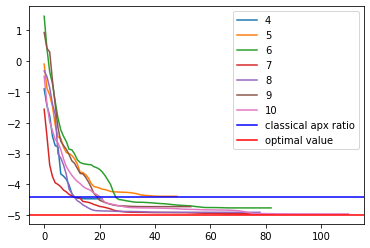

In [10]:
import matplotlib.pylab as plt


for nlayers in range(4,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

-0.14670987184304096 -0.895758004198362 -2.0308904847316818 -2.082794443622834 -2.1800476619570346 -2.3578588437582813 -2.6428424204039414 -2.9225319771493536 -3.017905956919383 -3.0803720902712377 -3.121610699311152 -3.313935636681837 -3.379604092241094 -3.4708850053802527 -3.5421843179530246 -3.565060253761964 -3.588438085864945 -3.595304752289351 -3.5957274633924063 -3.5957415367145535 -3.595744056714017 -3.595744058123532 -3.59574405813209 -0.7435656965801564 -2.482734442848728 -2.8032199014678514 -3.3970049482412152 -3.78716493872046 -3.941249597154956 -4.1529407921254196 -4.27091643572453 -4.312714769207924 -4.3439596879770965 -4.353268854212599 -4.369061641820127 -4.395296823666351 -4.42298993502176 -4.439612461895817 -4.461474538127258 -4.463772404277465 -4.463831445897166 -4.463832350620099 -4.463832540835234 -4.463832607351121 -4.463832632075398 -4.463832632303559 -0.7327863011627878 -2.7289570794034765 -3.230870019099371 -3.55148734103363 -3.9873857914356448 -4.1574415074910

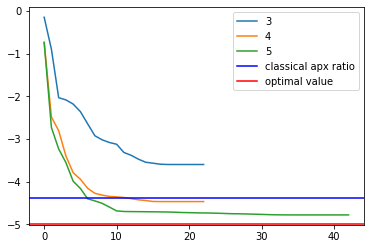

In [23]:
T = 1.

##we have a better convergence for the same number of layers: 5 layers model 
#was reaching classical apx ratio previously, now it is around avg of apx ratio and optimal value

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    p = nlayers
    deltaT = T/p

    #beta from algorithm 1 in paper is theta and gamma is beta
    theta_ = [(1-(k+1)/(p))*deltaT for k in range(p)]
    beta_ = [(k+1)*deltaT/(p) for k in range(p)]

    #combine them into (theta_1 beta_1 ... theta_p+1 beta_p+1)

    parameters_init = sum(zip(theta_, beta_), ())
    """parameters_init = sum(zip(theta_, beta_+[0]), ())[:-1]
    parameters_init = [None]*2*len(theta_)
    parameters_init[::2] = theta_
    parameters_init[1::2] = beta_"""


    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.0620362686001297 -2.3718480377073305 -2.5744419673954315 -2.8482124836544687 -2.9885229663331234 -3.253326186016537 -3.7027579486677062 -3.9476416538695607 -3.975234728323882 -3.9759845987028415 -3.9772388602749453 -3.9782566430425663 -3.978267575555725 -3.978269029553248 -3.9782690296551024 -3.978269029656531 -0.04363057304221277 -2.572037526604155 -2.6156739305471417 -4.017363116132033 -4.030484639583899 -4.052927405623807 -4.235365198749605 -4.294392972343509 -4.375760370138558 -4.411082892960173 -4.430956509787124 -4.452585224269958 -4.4594058548489 -4.462054395682591 -4.463812040120011 -4.4638283029503105 -4.463832158976759 -4.463832615738463 -4.463832632056974 -4.463832632302245 -4.463832632305393 -0.04135866068321692 -0.27842515650587196 -0.7167936296871864 -0.9808232505848408 -2.9726786304361763 -3.036219491457607 -3.5397515742233323 -3.782938162372587 -3.8931902305136212 -4.084494782056308 -4.324074487382783 -4.575651238756079 -4.6234939661316945 -4.650677760162701 -4.66841

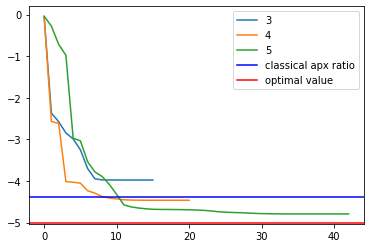

In [24]:
T = .2


for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    p = nlayers
    deltaT = T/p

    #beta from algorithm 1 in paper is theta and gamma is beta
    theta_ = [(1-(k+1)/(p))*deltaT for k in range(p)]
    beta_ = [(k+1)*deltaT/(p) for k in range(p)]

    #combine them into (theta_1 beta_1 ... theta_p+1 beta_p+1)

    parameters_init = sum(zip(theta_, beta_), ())
    """parameters_init = sum(zip(theta_, beta_+[0]), ())[:-1]
    parameters_init = [None]*2*len(theta_)
    parameters_init[::2] = theta_
    parameters_init[1::2] = beta_"""


    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

-0.0016935449068443131 -1.5493208571611203 -2.262712253707379 -2.7034249181069328 -2.8988868273414954 -3.2412640290913344 -3.519180006975825 -3.566782760920546 -3.5841392236886724 -3.5931410644201374 -3.595678858353 -3.5957404069230465 -3.5957440551329927 -3.5957440581271016 -3.5957440581321047 -0.49487079267755724 -1.3365744370785118 -1.6547009101374706 -2.168074154416835 -2.317288823533968 -2.439585719954364 -2.471750487476664 -2.472855916481553 -2.4744307690125282 -2.4759564414711597 -2.478677912795066 -2.483387245888406 -2.4885232762729577 -2.4894053082721754 -2.489494570390441 -2.48953081606158 -2.489538438833705 -2.4895431398596117 -2.4895521581608593 -2.489569461736158 -2.489601975100418 -2.4896584668571795 -2.4897163920158056 -2.489750547750753 -2.4897869128047883 -2.48979427393911 -2.4897943752424907 -2.4897944121819493 -2.489794412709149 -2.489794412863757 -2.489794413019954 -2.4897944130241534 -1.6017616840859943 -2.163251951507414 -2.973880817949452 -3.2148868705924514 -3.3

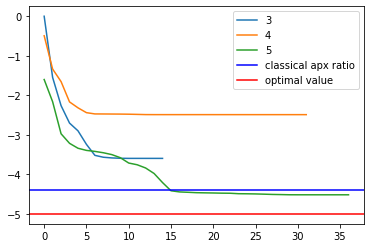

In [25]:
T = 5


for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    p = nlayers
    deltaT = T/p

    #beta from algorithm 1 in paper is theta and gamma is beta
    theta_ = [(1-(k+1)/(p))*deltaT for k in range(p)]
    beta_ = [(k+1)*deltaT/(p) for k in range(p)]

    #combine them into (theta_1 beta_1 ... theta_p+1 beta_p+1)

    parameters_init = sum(zip(theta_, beta_), ())
    """parameters_init = sum(zip(theta_, beta_+[0]), ())[:-1]
    parameters_init = [None]*2*len(theta_)
    parameters_init[::2] = theta_
    parameters_init[1::2] = beta_"""


    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    
    plt.plot(back_trace,label=str(nlayers))

plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()